# Cats and Dogs: Transferência de Aprendizado

Serão apresentadas as técnicas de *transfer learning* e *fine tunning*. Elas consistem em
utilizar uma rede vencedora da competição anual ImageNet, tanto sua arquitetura como seus
parâmetros treinados em uma outra aplicação envolvendo imagens.

A ideia consiste em utilizar as camadas convolucionais da rede vencedora e trocar apenas as
camadas densas. Num primeiro momento, treina-se apenas as camadas densas (*transfer learning*)
e após este treinamento inicial, continua-se o treinamento com as camadas densas e 
algumas últimas camadas convolucionais da rede (*fine tuning*)

Neste notebook utilizam-se as camadas convolucionais de uma rede ResNet já treinada para gerar as "características" das imagens e treina-se com uma rede neural densa de duas camadas. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import os, glob
import PIL.Image

import numpy as np
import torch
from torch import nn
import torch.utils.data
import torch.optim.lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision.models.resnet import BasicBlock

from lib import pytorch_trainer as ptt
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


## Dataset

In [2]:
class CatsDogsDataset(torch.utils.data.Dataset):
    def __init__(self, rootdir, train=True, transform=None):
        self.train = train
        self.transform = transform
        if self.train:
            self.dirpath = os.path.join(rootdir, 'train')
        else:
            self.dirpath = os.path.join(rootdir, 'validation')
        print(self.dirpath)
        self.l_filepaths = [fp for fp in sorted(glob.glob(os.path.join(self.dirpath, '**'), recursive=True))
                          if fp[-4:].lower() == '.jpg']
    def __len__(self):
        return len(self.l_filepaths)
    def __getitem__(self, index):
        fp = self.l_filepaths[index]
        out = int(os.path.basename(fp)[:3].lower() == 'dog')
        inp = PIL.Image.open(fp)
        if self.transform is not None:
            inp = self.transform(inp)
        return inp, out

In [3]:
rootdir = '/data/datasets/catsdogs_fewsamples'
size_final = (150, 150)
transf_comp_train = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_final),
                                                    torchvision.transforms.ToTensor()])

transf_comp_valid = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_final),
                                                    torchvision.transforms.ToTensor()])

dataset_train = CatsDogsDataset(rootdir, train=True, transform=transf_comp_train)
dataset_valid = CatsDogsDataset(rootdir, train=False, transform=transf_comp_valid)

/data/datasets/catsdogs_fewsamples/train
/data/datasets/catsdogs_fewsamples/validation


## Data Loader

In [4]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
x_train, y_train = next(iter(loader_train))
x_valid, y_valid = next(iter(loader_valid))

## Construção da rede neural
O *transfer learning* permite que utilizemos uma rede já treinada (a *ResNet34*, utilizando apenas uma parte convolucional da rede) para gerar um vetor de features. Essa primeira parte do modelo será chamado de *MyResNetConv*.

É possível utilizar esse vetor de features como entrada de uma rede densa simples, que terá como *output* a saída que será comparada com o resultado desejado. Essa parte final do modelo será chamada de *MyResNetDens*.

Essas duas partes serão integradas no modelo *MyResNet*, com o benefício de podermos utilizar a primeira parte para gerar as *features* convolucionais, que serão utilizadas no treinamento exclusivo da segunda parte.

### Modelos: mrn_conv, mrn_dens e o model básico

São criadas duas classes: rede convolucional e da rede densa.
A classe MyResNet instancia as duas classes referente às redes convolucional e densa.
Dessa forma é possível treinar as redes separadamente e chamá-las diretamente pela
rede principal.

A codificação da rede ResNet está disponível em:
https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

In [5]:
class MyResNetConv(torchvision.models.ResNet):
    def __init__(self):
        super().__init__(BasicBlock, [3, 4, 6, 3]) # ResNet34
        self.load_state_dict(torch.utils.model_zoo.load_url(
            'https://download.pytorch.org/models/resnet34-333f7ec4.pth'))
        del self.layer4
        del self.fc
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
#         x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

class MyResNetDens(nn.Module):
    def __init__(self):
        super().__init__()
        self.dens1 = nn.Linear(in_features=256, out_features=50)
        self.relu1 = nn.ReLU()
        self.dens2 = nn.Linear(in_features=50, out_features=2)

    def forward(self, x):
        x = self.dens1(x)
        x = self.relu1(x)
        x = self.dens2(x)
        return x

class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mrn_conv = MyResNetConv() # instância rede convolucional
        self.mrn_dens = MyResNetDens() # instância rede densa

    def forward(self, x):
        x = self.mrn_conv(x)
        x = self.mrn_dens(x)
        return x

model = MyResNet()
if use_gpu:
    model = model.cuda()
print(model)

MyResNet (
  (mrn_conv): MyResNetConv (
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (layer1): Sequential (
      (0): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), st

## Testando o predict: mrn_conv, mrn_dens e model

In [6]:
xin = Variable(x_train[:1])
if use_gpu:
    xin = xin.cuda()
o1 = model.mrn_conv(xin)
print('output of model.mrn_conv:', o1.data.size())

o2 = model.mrn_dens(o1)
print('output of model.mrn_dens:', o2.data.size())

o0 = model(xin)
print('\noutput of model:', o0.data.size())

output of model.mrn_conv: torch.Size([1, 256])
output of model.mrn_dens: torch.Size([1, 2])

output of model: torch.Size([1, 2])


## Geração de *features* convolucionais

A técnica aqui é fazer o predict de todo o dataset apenas uma única vez
na rede convolucional pré treinada e guardar os resultados (*features*).
Desta forma, para se treinar a rede densa, usa-se as *features* de entrada
sem necessidade de executar a rede convolucional pré treinada durante o
treinamento das camadas densas.

In [7]:
inp_train = x_train
inp_valid = x_valid
if use_gpu:
    inp_train = inp_train.cuda()
    inp_valid = inp_valid.cuda()
inp_train = Variable(inp_train)
inp_valid = Variable(inp_valid)

model.mrn_conv.eval()
feat_train = model.mrn_conv(inp_train).data
feat_valid = model.mrn_conv(inp_valid).data

print('training features:  ', feat_train.size())
print('validation features:', feat_valid.size())

training features:   torch.Size([2000, 256])
validation features: torch.Size([800, 256])


## Treinamento da camada densa utilizando as *features*: mrn_dens

In [8]:
n_epochs = 10
optm = torch.optim.Adam(params=model.mrn_dens.parameters(), lr=1.e-2, betas=(0.9, 0.999))
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)
cb_chkpt = ptt.ModelCheckpoint('../../models/transferlearning_features_catsdogs', reset=True, verbose=1)

trainer_dens = ptt.DeepNetTrainer(model         = model.mrn_dens,
                                  criterion     = nn.CrossEntropyLoss(),
                                  optimizer     = optm,
                                  lr_scheduler  = schd,
                                  callbacks = [ptt.AccuracyMetric(), 
                                               ptt.PrintCallback(), 
                                               cb_chkpt])

In [9]:
train = True
if train:
    trainer_dens.fit(n_epochs   = n_epochs,
                     Xin        = feat_train,
                     Yin        = y_train,
                     shuffle    = True,
                     batch_size = 100,
                     valid_data = (feat_valid, y_valid))
else:
    trainer_dens.load_state('/data/models/transferlearning_features_catsdogs')

Start training for 10 epochs
  1:   0.0s   T: 0.47112 0.79050   V: 0.22884 0.92000 best
  2:   0.0s   T: 0.20832 0.91950   V: 0.20942 0.91000 best
  3:   0.0s   T: 0.17694 0.92250   V: 0.14566 0.93625 best
  4:   0.0s   T: 0.14635 0.93550   V: 0.13830 0.94375 best
  5:   0.0s   T: 0.13322 0.94650   V: 0.14404 0.93500 
  6:   0.0s   T: 0.12466 0.94750   V: 0.14489 0.93375 
  7:   0.0s   T: 0.11528 0.95300   V: 0.13842 0.94000 
  8:   0.0s   T: 0.12055 0.94750   V: 0.14206 0.94875 
  9:   0.0s   T: 0.11407 0.94900   V: 0.13927 0.94750 
 10:   0.0s   T: 0.10744 0.95300   V: 0.24555 0.92125 
Stop training at epoch: 10/10
Best model was saved at epoch 4 with loss 0.13830: ../../models/transferlearning_features_catsdogs


In [10]:
def show_history(trainer):
    idx = np.argmin(trainer.metrics['valid']['losses'])
    idx = min(idx, len(trainer.metrics['valid']['acc']) - 1)
    fig = plt.figure(figsize=(10, 4), dpi=100)
    ax = fig.add_subplot(1, 2, 1)
    a_epochs = np.arange(1, 1 + len(trainer.metrics['train']['losses']))
    ax.plot(a_epochs, trainer.metrics['train']['losses'], label='training')
    a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['losses']))
    ax.plot(a_epochs, trainer.metrics['valid']['losses'], label='validation')
    ax.set_title('best validation loss: {:.2f}'.format(trainer.metrics['valid']['losses'][idx]))
    ax.plot(idx + 1, trainer.metrics['valid']['losses'][idx], 'kx')
    ax.legend()
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    a_epochs = np.arange(1, 1 + len(trainer.metrics['train']['acc']))
    ax.plot(a_epochs, trainer.metrics['train']['acc'], label='training')
    a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['acc']))
    ax.plot(a_epochs, trainer.metrics['valid']['acc'], label='validation')
    ax.set_title('best loss\' validation accuracy: {:.2f}'.format(trainer.metrics['valid']['acc'][idx]))
    ax.plot(idx + 1, trainer.metrics['valid']['acc'][idx], 'kx')
    ax.legend()
    ax.grid(True)
    plt.show()

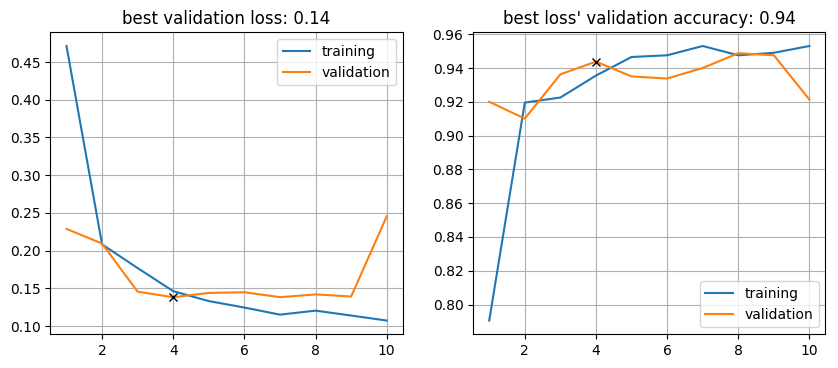

In [11]:
show_history(trainer_dens)

In [12]:
trainer_dens.load_state('../../models/transferlearning_features_catsdogs')
acc_val = trainer_dens.evaluate(feat_valid,y_valid, batch_size=100, metrics=[ptt.AccuracyMetric()])
print('acc_val:', acc_val)

evaluate: 7/7 ok
acc_val: {'losses': 0.13829834945499897, 'acc': 0.94375}


## Fine tunning
É possível ainda refazer o treinamento da camada densa junto com a parte convolucional da rede *ResNet*, utilizando um *learning rate* com valor bem baixo.

In [13]:
for param in model.parameters():
    param.requires_grad = True

## Agora os dados de entrada são os dados originais. Criando os loaders

In [14]:
batch_size = 200
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

## Preparando para treinar

In [15]:
n_epochs = 5
optm = torch.optim.Adam(params=model.parameters(),  lr=1.e-4)
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)
cb_chkpt = ptt.ModelCheckpoint('../../models/transferlearning_finetunning_catsdogs', 
                               reset=True, verbose=1)

trainer_finetunning = ptt.DeepNetTrainer(model         = model,
                                         criterion     = nn.CrossEntropyLoss(),
                                         optimizer     = optm,
                                         lr_scheduler  = schd,
                                         callbacks = [ptt.AccuracyMetric(), 
                                                      ptt.PrintCallback(),
                                                      cb_chkpt])

In [16]:
train = False
if train:
    trainer_finetunning.fit_loader(n_epochs, loader_train, loader_valid)
else:
    trainer_finetunning.load_state('/data/models/transferlearning_finetunning_catsdogs')

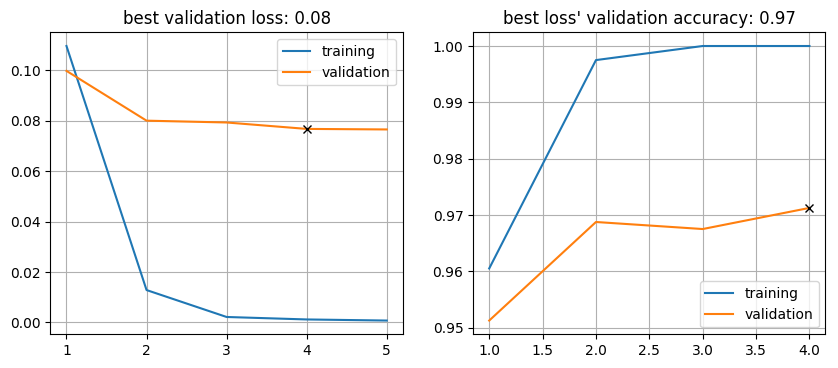

In [17]:
show_history(trainer_finetunning)

In [18]:
trainer_finetunning.load_state('/data/models/transferlearning_finetunning_catsdogs')
acc = trainer_finetunning.evaluate_loader(loader_valid,
                                    metrics=[ptt.AccuracyMetric()])

print('acc:',acc)

evaluate: 3/3 ok
acc: {'losses': 0.07654391881078482, 'acc': 0.9775}


## Exercícios

1. Veja a codificação da rede ResNet (veja o link no github) e explique a inicialização
   da classe do modelo: `super().__init__(BasicBlock, [3, 4, 6, 3])`
2. Observe que a camada densa (`fc`) da ResNet foi suprimida (`del self.fc`). Qual é a
   implicação caso ela não fosse removida? Experimente.
3. Qual é a célula deste notebook que inicializa os pesos de todas as redes?
4. Quantos parâmetros são treinados durante o *transfer learning* da primeira etapa?

## Atividade

1. Utilize a rede ResNet18 e a ResNet50 para fazer o *transfer learning*. 
   Compare os resultados.

## Aprendizados com este notebook
